# Fit Single Region
In this example, we are going to fit a single region of the science verification Abell 426 data cube (found at: [https://www.cfht.hawaii.edu/Instruments/Sitelle/SITELLE_sv.php](https://www.cfht.hawaii.edu/Instruments/Sitelle/SITELLE_sv.php)).

We will read in the data as usual using a `LUCI` cube object. We then will extract a background region and plot it. We will then extract a spectrum from a square
region around 1357<x<1367 and 608<y<618. These values were chosen to correspond with the brighest region of the horseshoe. Finally, we use the `LuciFit` Fit object to fit the region. 

The regions can be found in *Examples/regions*.

In [1]:
# Imports
import sys
sys.path.insert(0, '/home/carterrhea/Documents/LUCI/')  # Location of Luci
from LuciBase import Luci
import LUCI.LuciPlotting as lplt
import matplotlib.pyplot as plt
import LUCI.LuciFit as lfit
from astropy.io import fits
import numpy as np
import keras

2022-09-08 12:13:25.075097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-08 12:13:25.075122: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Set Parameters
# Using Machine Learning Algorithm for Initial Guess
Luci_path = '/home/carterrhea/Documents/LUCI/'
cube_dir = '/home/carterrhea/Documents/LUCI_test'  # Path to data cube
cube_name = 'NGC6946_SN3'  # don't add .hdf5 extension
object_name = 'NGC6946'
redshift = 0.000133
resolution = 1000 # The actual resolution is 400, but we don't have machine learning algorithms for that resolution, so we use 1000

### Create Luci object, extract background, and extract region to fit.

In [3]:
# Create Luci object
cube = Luci(Luci_path, cube_dir+'/'+cube_name, cube_dir, object_name, redshift, resolution)

Reading in data...


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  4.91it/s]


2022-09-08 12:13:30.574969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-08 12:13:30.575013: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-08 12:13:30.575056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-09-08 12:13:30.575243: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
cube.create_deep_image()

Existing deep frame extracted from hdf5 file.


100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 2599.45it/s]


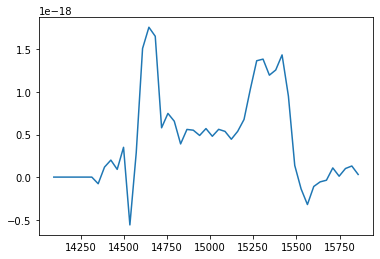

In [5]:
# Extract and visualize background
bkg_axis, bkg_sky = cube.extract_spectrum_region(cube_dir+'/bkg.reg', mean=True)  # We use mean=True to take the mean of the emission in the region instead of the sum
plt.plot(bkg_axis, bkg_sky)

### Fit and visualize

We are now going to fit a region (reg1) that we defined in ds9 separately. 

In [25]:
velocity_map, broadening_map, flux_map, chi2_map, mask = cube.fit_region(['Halpha', 'NII6548', 'NII6583', 'SII6716', 'SII6731'], 'gaussian', 
                                                                         [1,1,1,1,1], [1,1,1,1,1],
                                                                         region=cube_dir+'/reg1.reg',
                                                                         bkg=bkg_sky, n_threads=1)

100%|███████████████████████████████████████| 2064/2064 [14:31<00:00,  2.37it/s]


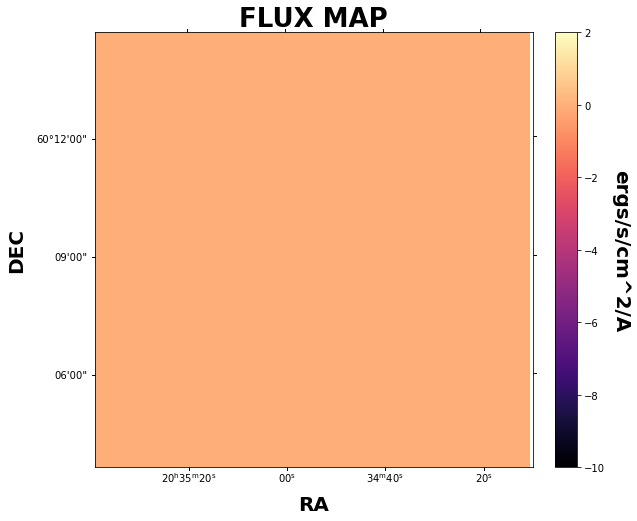

In [26]:
lplt.plot_map(np.log10(flux_map[:,:,0]), 'flux', cube_dir, cube.header, clims=[-10, 2])

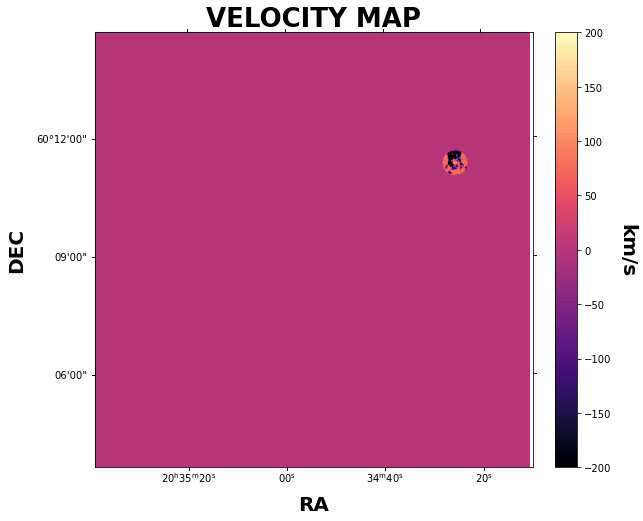

In [27]:
lplt.plot_map(velocity_map[:,:,0], 'velocity', cube_dir, cube.header, clims=[-200, 200])